#### Things we will learn here

- Summarization 

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Define ChatModel

from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

llm  = ChatOpenAI(model = "gpt-3.5-turbo")

# Define MessageState with summary key

class summaryMessagesState(MessagesState):
    summary: str

In [ ]:
# We will now define a node that uses this MessagesState
# The node will check if summary is present. If present , it will take that summary and add it as system message
# If not then nothing. 


from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def chat_node(state : summaryMessagesState):
    summary = state.get("summary", "")

    if summary:

        sys_msg = f"Here is a summary of our previous conversation: {summary}"
        messages = [SystemMessage(content = sys_msg)] + state["messages"]

    else:
        messages = state["messages"]

    return {"messages": llm.invoke(state["messages"])}

In [26]:
#We will now create a node to summarize our conversation

def summarize_node(state : summaryMessagesState):

    summary = state.get("summary", "")

    if summary:

        humanMsg = f"Here is the summary of our previous conversation: {summary}. Please provide an updated summary by taking into account the new messages above : "
        

    else:
        humanMsg = "Please provide a summary of the conversation : "
    
    messages = [HumanMessage(content = humanMsg)] + state["messages"]
    response = llm.invoke(state["messages"])

    delete_messages = [RemoveMessage(id=msg.id) for msg in state["messages"][:-2]]
                          
    return {"messages" : delete_messages, "summary" : response.content}


In [27]:
# A condition where we check if summarization is needed or not

from langgraph.graph import END
from typing_extensions import Literal

def summary_condition(state : summaryMessagesState) -> Literal["summarize_node", END]:

    if len(state["messages"]) > 6:
        return "summarize_node"
    
    return END

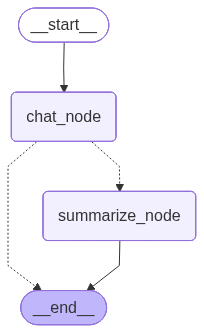

In [28]:
# Build a graph with memory

from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(summaryMessagesState)

builder.add_node("chat_node", chat_node)
builder.add_node("summarize_node", summarize_node)

builder.add_edge(START, "chat_node")
builder.add_conditional_edges("chat_node", summary_condition)
builder.add_edge("summarize_node", END)

graph = builder.compile(checkpointer=MemorySaver())

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Junaid")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like Fyodor Dostoevsky!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

Hello Junaid! How can I assist you today?
================================== Ai Message ==================================

Your name is Junaid.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

That's great to hear! Fyodor Dostoevsky is a renowned Russian novelist known for his deep psychological insights and complex characters. Do you have a favorite book or work by Dostoevsky?


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [29]:
input_message = HumanMessage(content="i like The Brothers Karamazov, isn't that his best work?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


================================== Ai Message ==================================

Many people consider The Brothers Karamazov to be Fyodor Dostoevsky's masterpiece, as it is a complex and profound exploration of morality, faith, and the human condition. However, some may argue that other works by Dostoevsky, such as Crime and Punishment or Notes from Underground, are equally important and impactful. Ultimately, it is a matter of personal preference and interpretation as to which of Dostoevsky's works is his best.


Failed to send compressed multipart ingest: langsmith.utils.LangSmithError: Failed to POST https://eu.api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('403 Client Error: Forbidden for url: https://eu.api.smith.langchain.com/runs/multipart', '{"error":"Forbidden"}\n')


In [32]:
graph.get_state(config).values.get("summary","")

''